In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 6.360167980194092
(14019, 1, 11025)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 44, 1)        296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 5s 2s/step - loss: 1427.9327
(1, 11025)


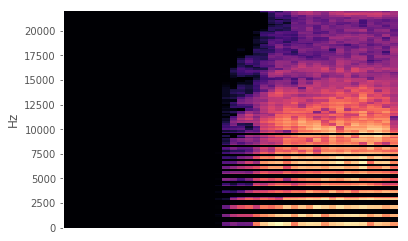

(14019, 128, 44)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
frames = mfccs

In [19]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(14019, 128, 44, 1)

In [20]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 36, 32)       2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

Epoch 76/100
9532/9532 [==============================] - 4s 424us/step - loss: 0.3108 - acc: 0.8490 - mean_absolute_error: 0.2140 - val_loss: 0.4754 - val_acc: 0.7950 - val_mean_absolute_error: 0.2688
Epoch 77/100
9532/9532 [==============================] - 4s 429us/step - loss: 0.3152 - acc: 0.8504 - mean_absolute_error: 0.2151 - val_loss: 0.4636 - val_acc: 0.7926 - val_mean_absolute_error: 0.2628
Epoch 78/100
9532/9532 [==============================] - 4s 431us/step - loss: 0.3131 - acc: 0.8524 - mean_absolute_error: 0.2151 - val_loss: 0.5202 - val_acc: 0.7849 - val_mean_absolute_error: 0.2602
Epoch 79/100
9532/9532 [==============================] - 4s 449us/step - loss: 0.3085 - acc: 0.8530 - mean_absolute_error: 0.2106 - val_loss: 0.4631 - val_acc: 0.7950 - val_mean_absolute_error: 0.2605
Epoch 80/100
9532/9532 [==============================] - 4s 427us/step - loss: 0.3026 - acc: 0.8585 - mean_absolute_error: 0.2088 - val_loss: 0.4719 - val_acc: 0.7974 - val_mean_absolute_erro

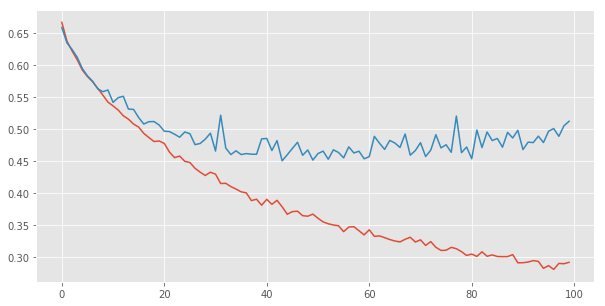

In [21]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

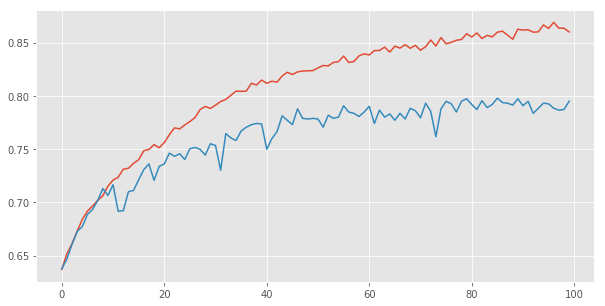

In [22]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.797432239657632
Confusion matrix, without normalization
[[ 619  424]
 [ 144 1617]]


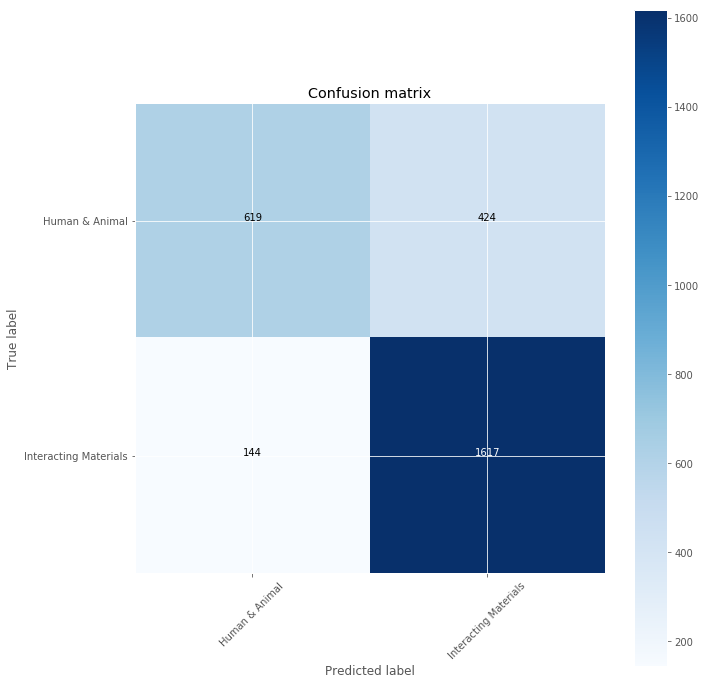

In [23]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [24]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [25]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [26]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

Epoch 71/200
3515/3515 [==============================] - 2s 490us/step - loss: 1.4035 - acc: 0.5565 - mean_absolute_error: 0.0610 - val_loss: 1.3967 - val_acc: 0.5668 - val_mean_absolute_error: 0.0602
Epoch 72/200
3515/3515 [==============================] - 2s 495us/step - loss: 1.3483 - acc: 0.5693 - mean_absolute_error: 0.0597 - val_loss: 1.3855 - val_acc: 0.5556 - val_mean_absolute_error: 0.0600
Epoch 73/200
3515/3515 [==============================] - 2s 490us/step - loss: 1.3344 - acc: 0.5764 - mean_absolute_error: 0.0589 - val_loss: 1.3158 - val_acc: 0.5974 - val_mean_absolute_error: 0.0578
Epoch 74/200
3515/3515 [==============================] - 2s 495us/step - loss: 1.3519 - acc: 0.5696 - mean_absolute_error: 0.0596 - val_loss: 1.3541 - val_acc: 0.5894 - val_mean_absolute_error: 0.0578
Epoch 75/200
3515/3515 [==============================] - 2s 499us/step - loss: 1.3568 - acc: 0.5704 - mean_absolute_error: 0.0590 - val_loss: 1.3469 - val_acc: 0.6023 - val_mean_absolute_erro

3515/3515 [==============================] - 2s 491us/step - loss: 1.0775 - acc: 0.6492 - mean_absolute_error: 0.0485 - val_loss: 1.2258 - val_acc: 0.6280 - val_mean_absolute_error: 0.0520
Epoch 152/200
3515/3515 [==============================] - 2s 490us/step - loss: 1.0433 - acc: 0.6677 - mean_absolute_error: 0.0474 - val_loss: 1.2459 - val_acc: 0.6103 - val_mean_absolute_error: 0.0511
Epoch 153/200
3515/3515 [==============================] - 2s 495us/step - loss: 1.0548 - acc: 0.6589 - mean_absolute_error: 0.0476 - val_loss: 1.2462 - val_acc: 0.6119 - val_mean_absolute_error: 0.0519
Epoch 154/200
3515/3515 [==============================] - 2s 491us/step - loss: 1.0411 - acc: 0.6646 - mean_absolute_error: 0.0470 - val_loss: 1.2282 - val_acc: 0.6264 - val_mean_absolute_error: 0.0506
Epoch 155/200
3515/3515 [==============================] - 2s 486us/step - loss: 1.0102 - acc: 0.6717 - mean_absolute_error: 0.0466 - val_loss: 1.2190 - val_acc: 0.6345 - val_mean_absolute_error: 0.0494

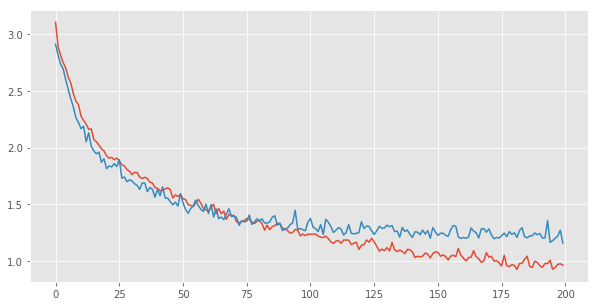

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

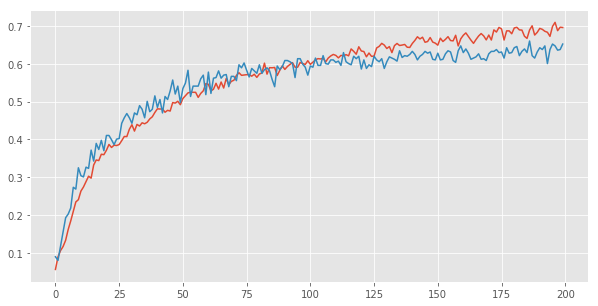

In [28]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.6183574879227053
Confusion matrix, without normalization
[[39  0  0  1  0  2  2  0  0  2  0  0  1  2  0  0  1  3  0]
 [ 3 21  1  5  4  0  1  0  0  3  0  0  0  1  0  0  1  2  0]
 [ 0  0 45  0  0  0  4  1  0  1  0  0  0  0  2  1  1  0  0]
 [ 2  1  1 27  0  0  5  8  2  5  0  0  1  7  0  1  0  2  2]
 [ 1  3  0  0 38  0  0  1  1  0  0  0  0  0  1  0  1  1  1]
 [ 0  1  0  1  0 30  0  1  1  1  0  2  5  2  0  0  2  0  3]
 [ 0  1 11  0  0  2 29  0  0  4  0  1  1  0  2  1  1  2  1]
 [ 0  1  6  0  0  0  0 26  1  3  0  0  0  0  0  0  1  1  9]
 [ 5  0  0  0  2  1  4  3 54  3  0  1  2  0  0  0  0  1  2]
 [ 0  0  1  3  2  0  0  4  0 42  1  0  0  4  0  0  0  0  1]
 [ 0  0  1  0  0  0  0  2  0  2 65  2  0  0  0  0  0  0  1]
 [ 1  0  0  0  3  3  1  1  0  1  1 46  1  1  0  0  0  0  3]
 [ 2  1  3  1  2  2 10  1  2  0  0  2 20  2  1  0  3  2  5]
 [ 0  0  2  0  1  0  0  1  0  1  0  3  1 17  1  0  0  1  1]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 57  0  0  0  0]
 [ 0  0  3  0  2  1  1  2  1  2  0  0  0 

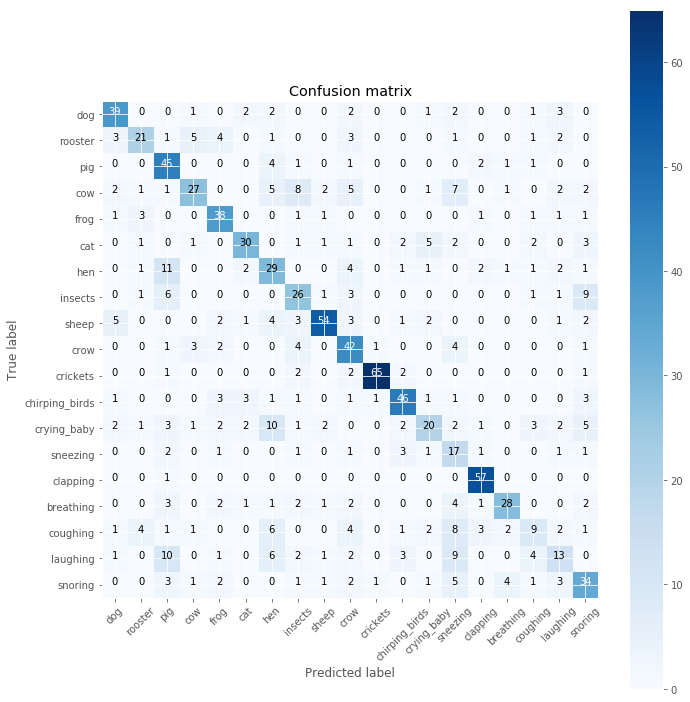

In [29]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [30]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [31]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [32]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 16)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

Epoch 71/200
6016/6016 [==============================] - 3s 518us/step - loss: 1.6957 - acc: 0.4297 - mean_absolute_error: 0.0451 - val_loss: 1.6676 - val_acc: 0.4614 - val_mean_absolute_error: 0.0438
Epoch 72/200
6016/6016 [==============================] - 3s 514us/step - loss: 1.6419 - acc: 0.4555 - mean_absolute_error: 0.0443 - val_loss: 1.6189 - val_acc: 0.4831 - val_mean_absolute_error: 0.0427
Epoch 73/200
6016/6016 [==============================] - 3s 549us/step - loss: 1.6116 - acc: 0.4604 - mean_absolute_error: 0.0437 - val_loss: 1.6176 - val_acc: 0.4868 - val_mean_absolute_error: 0.0423
Epoch 74/200
6016/6016 [==============================] - 3s 519us/step - loss: 1.6299 - acc: 0.4485 - mean_absolute_error: 0.0441 - val_loss: 1.6744 - val_acc: 0.4529 - val_mean_absolute_error: 0.0432
Epoch 75/200
6016/6016 [==============================] - 3s 549us/step - loss: 1.6604 - acc: 0.4395 - mean_absolute_error: 0.0444 - val_loss: 1.6568 - val_acc: 0.4680 - val_mean_absolute_erro

6016/6016 [==============================] - 3s 546us/step - loss: 1.3426 - acc: 0.5494 - mean_absolute_error: 0.0378 - val_loss: 1.4923 - val_acc: 0.5320 - val_mean_absolute_error: 0.0377
Epoch 152/200
6016/6016 [==============================] - 3s 533us/step - loss: 1.3584 - acc: 0.5429 - mean_absolute_error: 0.0380 - val_loss: 1.4161 - val_acc: 0.5527 - val_mean_absolute_error: 0.0359
Epoch 153/200
6016/6016 [==============================] - 3s 515us/step - loss: 1.3782 - acc: 0.5372 - mean_absolute_error: 0.0381 - val_loss: 1.4570 - val_acc: 0.5433 - val_mean_absolute_error: 0.0374
Epoch 154/200
6016/6016 [==============================] - 3s 520us/step - loss: 1.3966 - acc: 0.5301 - mean_absolute_error: 0.0385 - val_loss: 1.4187 - val_acc: 0.5659 - val_mean_absolute_error: 0.0372
Epoch 155/200
6016/6016 [==============================] - 3s 553us/step - loss: 1.3553 - acc: 0.5459 - mean_absolute_error: 0.0379 - val_loss: 1.4386 - val_acc: 0.5499 - val_mean_absolute_error: 0.0368

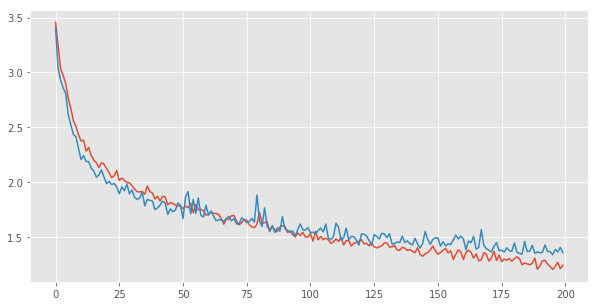

In [33]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

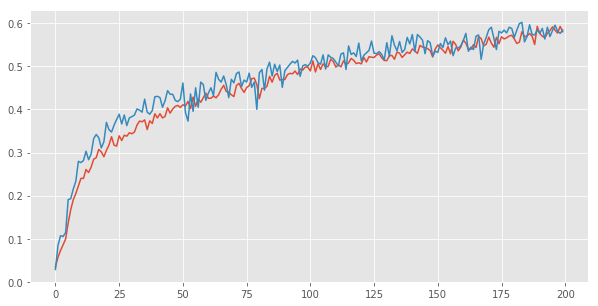

In [34]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.5898305084745763
Confusion matrix, without normalization
[[48  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  6  0  0  0  0  1  0  0
   0  0  0  0  2  0  0]
 [ 1 42  0  0  0  0  6  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0  5  0
   0  4  1  0  0  0  0]
 [ 0  0 40  0  0  1  0  0  1  3  0  0  0 10  0  2  0  0  0  0  0  0  1  0
   0  0  0  0  0  0  0]
 [ 0  0  0 21  0  1  0  2  1  0  0  0  2  1  1  0  0  0  5  7  3  0  0  0
   0  0  0  0  0  2  0]
 [ 5  9  0  0 38  0  0  0  0  0  0  0  0  0  0  0  1  3  0  0  0  0  4  0
   0  3  5  1  0  0  0]
 [ 0  0  2  0  0 19  0  0  3  1  1  0  1  9  0  2  0  0  2  0  1  0  1  0
   0  1  0  0  0  0  0]
 [ 4  1  1  0  0  0 26  1  0  7  0  0  0  0  0  0  0  2  3  0  0  1  1  1
   0  2  1  0  0  1  0]
 [ 0  1  0  0  2  0  1 36  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1
   0  3  3  0 11  2  0]
 [ 0  0  4  0  1  1  0  3 27  0  0  0  2  6  1  0  0  0  0  4  0  0  0  0
   0  0  0  0  0  1  1]
 [ 0  0  6  0  1  1  1  2  1 37  0  0  0  0  1  0  0  1  2 

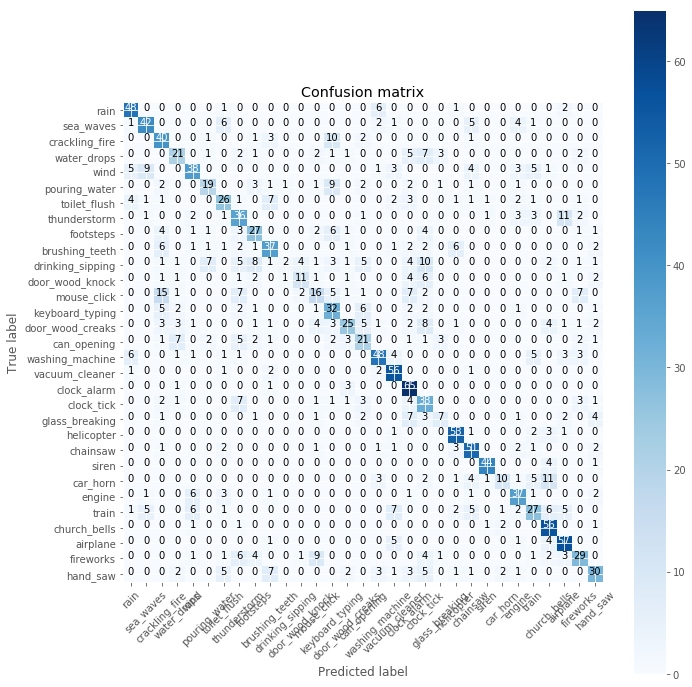

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 6.218747615814209
	Processing Time: 5.940847873687744
	Processing Time: 5.538389682769775
	Processing Time: 5.817198276519775


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


0.7172473315249939
Confusion matrix, without normalization
[[10463 10641]
 [ 5412 30258]]


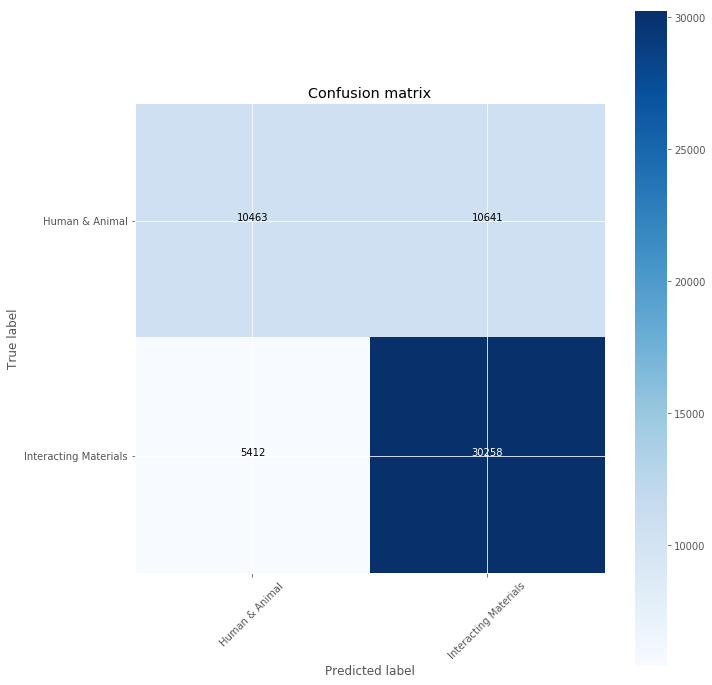

In [40]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [41]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.305724033358605
Confusion matrix, without normalization
[[497  28  38  41  32  14 136   2  25  19   0   4  17  85  31  23  40  57
   18]
 [ 87 302   8  42  21  26  65   0  17  60   4  15  21 133   4   3  23  39
   15]
 [ 14   4 343  21  19   6  62  68  26  61  16  25  19  21 180  27  68  29
   67]
 [103  14  55 313  17  22 234  32  65  47   8  17  36  26   8  30  16  38
   32]
 [ 88 102  51  19 360   2  14   6  80 130   3  70   3  22 236  20  14  10
   14]
 [136 111   6 120  28  95  70  31  39  47   4  11  64  66  20   8  34  62
   77]
 [160  21 109  46  23  12 365  53  13  12  11   5  71  14  14  58  56  84
   26]
 [ 53   0 196  86  37  31  55 436  57  32   5  20  26   6  61  21  11  10
   68]
 [ 41  11  96  58  68  27  95  81 364 154   6  38  13   5  60  21  17  48
   31]
 [ 64  13  89  72 151   0  46  55  65 447   9  22   1   8  51   9   3  11
   21]
 [ 58   0  54  25   6   1   6 103   4 138 185 487   0  41   3   7   1   1
  128]
 [ 39   7 112  21  16  12  34  62  46  35 104 565  

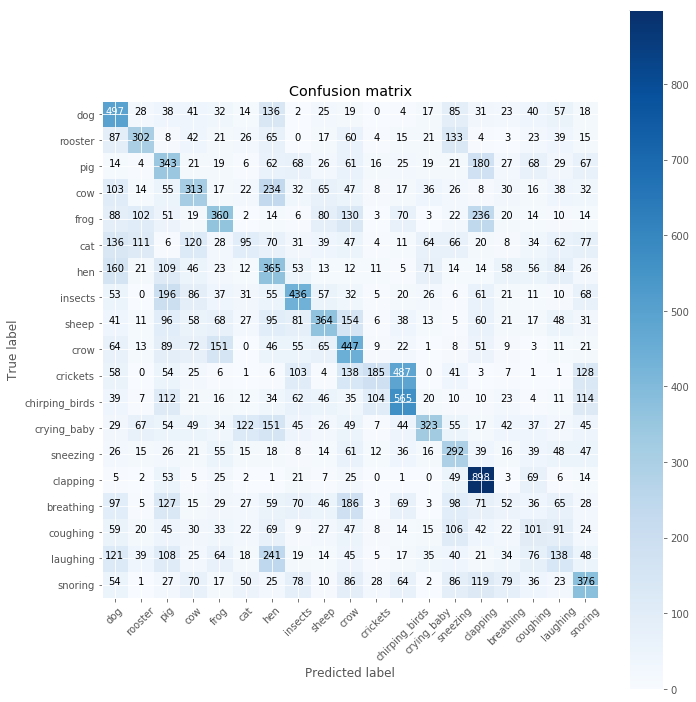

In [42]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.19394449116904963
Confusion matrix, without normalization
[[264  24   2   0  18   2 453   8   0   9   0   0   0   0  23   1  27  28
    0   0  56  50  20   0   0  28   0   0 232   0   3]
 [ 27 240   3   1  19   0 535   4   0   3   0   0   1   0   1   0  41  37
    4   0   0  38 181   0   8  46   9  16  26   0   2]
 [  7   8 296   1  18  83  92   9  63 122   0   2   9  51  81  20  11  45
    1  14   8  49 107   0   0  39   0   0   2  51  25]
 [  0   0  93  80   3  44   9  98  52  17   7  33  68  69  24  97   0   0
   54 129  32   1   7  14   1   4   1  18   0  26  51]
 [  0 171   0   0  98   0   8   8   2   6   0   1   0   0   0   0  15  16
    0   0   3   9 112 131  46  34 382 131  52   0  23]
 [  0   2 126  24   5 241 104   5  86  41  36  30   4  89  23  35   6   0
   63  46  30   6 104  23   2  15   0   0   0   6  29]
 [107  19  17   1   8   4 503  23   9 128   4   4  18   0   5   1  46  45
    3  14  21  47  74   5   2  36  19   1  42   1  31]
 [ 19   6   4  12  92  26  17 175   5

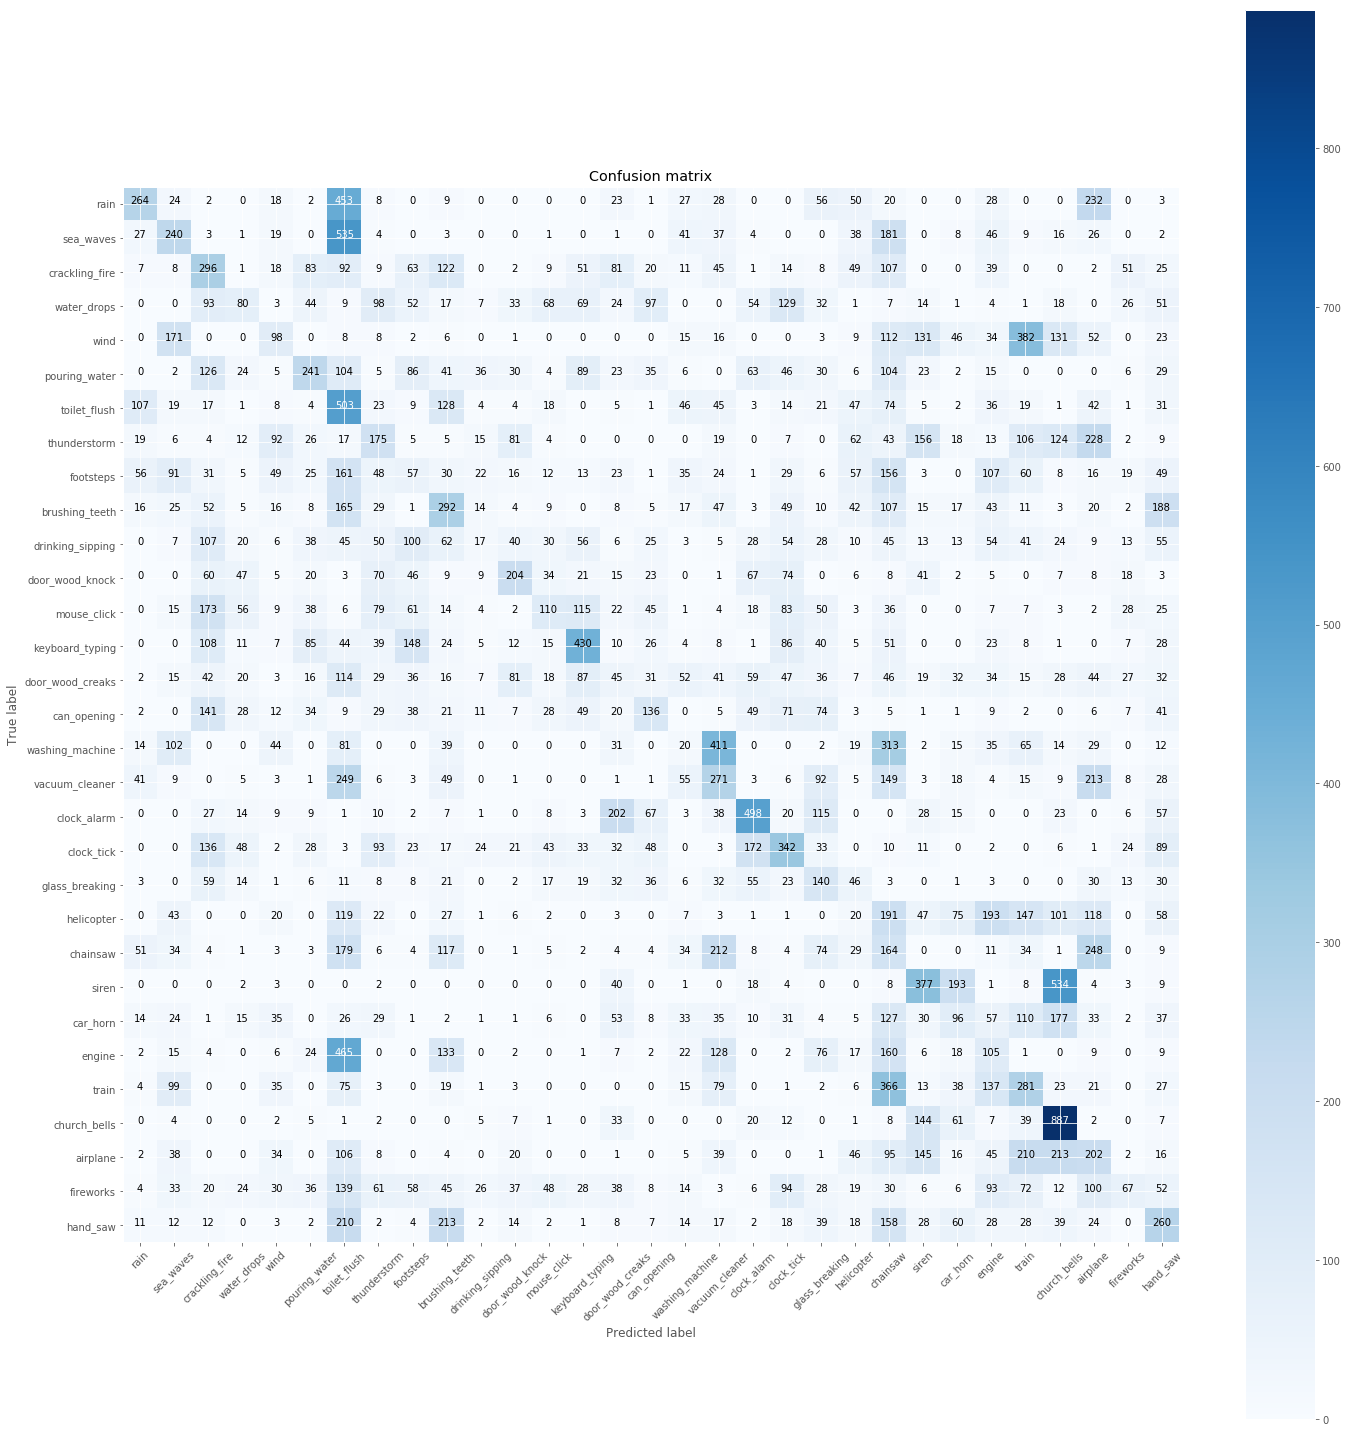

In [43]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, names_i)
plt.show()

In [44]:
clas.predict_proba(X)

array([[2.3841858e-07, 9.9999976e-01],
       [0.0000000e+00, 1.0000000e+00],
       [7.2497129e-04, 9.9927503e-01],
       ...,
       [3.1232649e-01, 6.8767351e-01],
       [3.2108659e-01, 6.7891341e-01],
       [3.2087886e-01, 6.7912114e-01]], dtype=float32)

# Testing Accuracy of Single File

In [45]:
data_iloc = 1

In [46]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_category)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [47]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.016314983367919922


In [48]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

39/39 [==============================] - 0s 325us/step


In [49]:
np.average(pred_prob, axis=0)

array([0.774686  , 0.22531399], dtype=float32)

In [50]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

39/39 [==============================] - 0s 333us/step


In [51]:
np.average(pred_prob, axis=0)

array([1.3340284e-05, 3.0619106e-03, 4.5353387e-02, 3.7008123e-03,
       8.1164122e-04, 5.8494456e-04, 1.6357683e-03, 1.5589204e-02,
       1.0045723e-03, 2.0716418e-02, 1.7487619e-03, 6.0834599e-01,
       1.3521442e-02, 2.8127939e-02, 3.2024964e-04, 1.0182745e-01,
       9.0810033e-03, 1.1347143e-02, 1.3320801e-01], dtype=float32)

In [52]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

14


In [53]:
print(dataset.iloc[data_iloc])

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


In [54]:
predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    top_pred_probs.append(clas.predict_proba(x_file))
    prob = np.average(top_pred_probs[-1], axis=0)
    if prob[0] > 0.5:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(anim.predict_proba(x_file))
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(inter.predict_proba(x_file))
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.00916600227355957
	Processing Time: 0.016678333282470703
	Processing Time: 0.014938116073608398
	Processing Time: 0.012398481369018555
	Processing Time: 0.011896133422851562
	Processing Time: 0.015870094299316406
	Processing Time: 0.011629819869995117
	Processing Time: 0.01335453987121582
	Processing Time: 0.015961647033691406
	Processing Time: 0.00895380973815918
	Processing Time: 0.016370773315429688
	Processing Time: 0.012605428695678711
	Processing Time: 0.011856555938720703
	Processing Time: 0.013357162475585938
	Processing Time: 0.0089569091796875
	Processing Time: 0.012829065322875977
	Processing Time: 0.012716531753540039
	Processing Time: 0.012588739395141602
	Processing Time: 0.014761924743652344
	Processing Time: 0.01587510108947754
	Processing Time: 0.014829158782958984
	Processing Time: 0.016956090927124023
	Processing Time: 0.0123138427734375
	Processing Time: 0.011870861053466797
	Processing Time: 0.019408702850341797
	Processing Time: 0.0158479213714

	Processing Time: 0.01523900032043457
	Processing Time: 0.01236414909362793
	Processing Time: 0.014177322387695312
	Processing Time: 0.0157167911529541
	Processing Time: 0.01408243179321289
	Processing Time: 0.012059450149536133
	Processing Time: 0.013066291809082031
	Processing Time: 0.011818885803222656
	Processing Time: 0.014377593994140625
	Processing Time: 0.012076854705810547
	Processing Time: 0.010043621063232422
	Processing Time: 0.009585380554199219
	Processing Time: 0.012201547622680664
	Processing Time: 0.01584625244140625
	Processing Time: 0.014029979705810547
	Processing Time: 0.01360774040222168
	Processing Time: 0.011624574661254883
	Processing Time: 0.011615276336669922
	Processing Time: 0.011701822280883789
	Processing Time: 0.02170419692993164
	Processing Time: 0.010956287384033203
	Processing Time: 0.013848304748535156
	Processing Time: 0.012143135070800781
	Processing Time: 0.011870861053466797
	Processing Time: 0.01247096061706543
	Processing Time: 0.01054358482360

	Processing Time: 0.015099763870239258
	Processing Time: 0.013737678527832031
	Processing Time: 0.015082597732543945
	Processing Time: 0.01354360580444336
	Processing Time: 0.01196908950805664
	Processing Time: 0.012279272079467773
	Processing Time: 0.011973142623901367
	Processing Time: 0.012225151062011719
	Processing Time: 0.015155315399169922
	Processing Time: 0.01399374008178711
	Processing Time: 0.014468193054199219
	Processing Time: 0.014223098754882812
	Processing Time: 0.012196063995361328
	Processing Time: 0.012336015701293945
	Processing Time: 0.011045217514038086
	Processing Time: 0.01344752311706543
	Processing Time: 0.015036344528198242
	Processing Time: 0.014472723007202148
	Processing Time: 0.012265205383300781
	Processing Time: 0.014903783798217773
	Processing Time: 0.027159690856933594
	Processing Time: 0.013336896896362305
	Processing Time: 0.012242555618286133
	Processing Time: 0.018111228942871094
	Processing Time: 0.011982917785644531
	Processing Time: 0.013462305

	Processing Time: 0.011553525924682617
	Processing Time: 0.013974189758300781
	Processing Time: 0.011864900588989258
	Processing Time: 0.015131711959838867
	Processing Time: 0.012207984924316406
	Processing Time: 0.011522769927978516
	Processing Time: 0.013207197189331055
	Processing Time: 0.009151220321655273
	Processing Time: 0.014611005783081055
	Processing Time: 0.011493206024169922
	Processing Time: 0.011636972427368164
	Processing Time: 0.01458287239074707
	Processing Time: 0.015969038009643555
	Processing Time: 0.014290332794189453
	Processing Time: 0.014793157577514648
	Processing Time: 0.013252735137939453
	Processing Time: 0.009810447692871094
	Processing Time: 0.01253819465637207
	Processing Time: 0.010268688201904297
	Processing Time: 0.012420654296875
	Processing Time: 0.07489538192749023
	Processing Time: 0.010426998138427734
	Processing Time: 0.062064170837402344
	Processing Time: 0.01203608512878418
	Processing Time: 0.08365225791931152
	Processing Time: 0.0137517452239

	Processing Time: 0.012205362319946289
	Processing Time: 0.01610589027404785
	Processing Time: 0.012318134307861328
	Processing Time: 0.011396646499633789
	Processing Time: 0.012062311172485352
	Processing Time: 0.011900663375854492
	Processing Time: 0.011490821838378906
	Processing Time: 0.011521339416503906
	Processing Time: 0.01144552230834961
	Processing Time: 0.011567115783691406
	Processing Time: 0.01616811752319336
	Processing Time: 0.015695571899414062
	Processing Time: 0.011667728424072266
	Processing Time: 0.011585712432861328
	Processing Time: 0.01613140106201172
	Processing Time: 0.01355743408203125
	Processing Time: 0.014308691024780273
	Processing Time: 0.015594482421875
	Processing Time: 0.012582778930664062
	Processing Time: 0.012530088424682617
	Processing Time: 0.012047052383422852
	Processing Time: 0.016089677810668945
	Processing Time: 0.014259815216064453
	Processing Time: 0.011144876480102539
	Processing Time: 0.012051820755004883
	Processing Time: 0.0139398574829

	Processing Time: 0.011845827102661133
	Processing Time: 0.016041040420532227
	Processing Time: 0.015729665756225586
	Processing Time: 0.009746789932250977
	Processing Time: 0.009176254272460938
	Processing Time: 0.01474308967590332
	Processing Time: 0.016495704650878906
	Processing Time: 0.011699676513671875
	Processing Time: 0.011506795883178711
	Processing Time: 0.015668392181396484
	Processing Time: 0.011737346649169922
	Processing Time: 0.01164388656616211
	Processing Time: 0.011996269226074219
	Processing Time: 0.011235713958740234
	Processing Time: 0.009335041046142578
	Processing Time: 0.00912618637084961
	Processing Time: 0.012901544570922852
	Processing Time: 0.012096166610717773
	Processing Time: 0.011774301528930664
	Processing Time: 0.011584758758544922
	Processing Time: 0.01648998260498047
	Processing Time: 0.01181936264038086
	Processing Time: 0.011630773544311523
	Processing Time: 0.01621246337890625
	Processing Time: 0.01287984848022461
	Processing Time: 0.010844945907

	Processing Time: 0.013550281524658203
	Processing Time: 0.012083053588867188
	Processing Time: 0.011662721633911133
	Processing Time: 0.008905887603759766
	Processing Time: 0.013019084930419922
	Processing Time: 0.01156163215637207
	Processing Time: 0.012952566146850586
	Processing Time: 0.011745691299438477
	Processing Time: 0.011573553085327148
	Processing Time: 0.012616395950317383
	Processing Time: 0.011657476425170898
	Processing Time: 0.010661602020263672
	Processing Time: 0.011577367782592773
	Processing Time: 0.011934995651245117
	Processing Time: 0.06103992462158203
	Processing Time: 0.011707305908203125
	Processing Time: 0.012592077255249023
	Processing Time: 0.05733823776245117
	Processing Time: 0.016917943954467773
	Processing Time: 0.01272439956665039
	Processing Time: 0.016394376754760742
	Processing Time: 0.015313386917114258
	Processing Time: 0.012052059173583984
	Processing Time: 0.01636505126953125
	Processing Time: 0.012046575546264648
	Processing Time: 0.0087902545

	Processing Time: 0.012373924255371094
	Processing Time: 0.0653836727142334
	Processing Time: 0.015390872955322266
	Processing Time: 0.012444496154785156
	Processing Time: 0.014283895492553711
	Processing Time: 0.013062000274658203
	Processing Time: 0.011652946472167969
	Processing Time: 0.016308069229125977
	Processing Time: 0.01181483268737793
	Processing Time: 0.011689901351928711
	Processing Time: 0.013608932495117188
	Processing Time: 0.011667728424072266
	Processing Time: 0.009311199188232422
	Processing Time: 0.024138450622558594
	Processing Time: 0.011971235275268555
	Processing Time: 0.011517763137817383
	Processing Time: 0.011543989181518555
	Processing Time: 0.032201528549194336
	Processing Time: 0.011649131774902344
	Processing Time: 0.015766620635986328
	Processing Time: 0.01615142822265625
	Processing Time: 0.01599407196044922
	Processing Time: 0.015453577041625977
	Processing Time: 0.011612892150878906
	Processing Time: 0.010335922241210938
	Processing Time: 0.0127758979

	Processing Time: 0.023565292358398438
	Processing Time: 0.012370586395263672
	Processing Time: 0.011758804321289062
	Processing Time: 0.011645793914794922
	Processing Time: 0.012458562850952148
	Processing Time: 0.011641979217529297
	Processing Time: 0.011533021926879883
	Processing Time: 0.01157379150390625
	Processing Time: 0.014275550842285156
	Processing Time: 0.012928009033203125
	Processing Time: 0.01337885856628418
	Processing Time: 0.014351129531860352
	Processing Time: 0.07615113258361816
	Processing Time: 0.011658906936645508
	Processing Time: 0.011662483215332031
	Processing Time: 0.012968063354492188
	Processing Time: 0.011675834655761719
	Processing Time: 0.011611461639404297
	Processing Time: 0.014251947402954102
	Processing Time: 0.06127572059631348
	Processing Time: 0.016116857528686523
	Processing Time: 0.012385129928588867
	Processing Time: 0.08032989501953125
	Processing Time: 0.011640071868896484
	Processing Time: 0.017632722854614258
	Processing Time: 0.0121552944

	Processing Time: 0.014203786849975586
	Processing Time: 0.013999462127685547
	Processing Time: 0.01176762580871582
	Processing Time: 0.014215946197509766
	Processing Time: 0.011896371841430664
	Processing Time: 0.01476907730102539
	Processing Time: 0.014198541641235352
	Processing Time: 0.011905670166015625
	Processing Time: 0.014530420303344727
	Processing Time: 0.011951208114624023
	Processing Time: 0.017117738723754883
	Processing Time: 0.011917352676391602
	Processing Time: 0.01657271385192871
	Processing Time: 0.030436277389526367
	Processing Time: 0.011713743209838867
	Processing Time: 0.011559009552001953
	Processing Time: 0.01162409782409668
	Processing Time: 0.01171422004699707
	Processing Time: 0.01747918128967285
	Processing Time: 0.011867761611938477
	Processing Time: 0.011608362197875977
	Processing Time: 0.016612768173217773
	Processing Time: 0.012572050094604492
	Processing Time: 0.015166282653808594
	Processing Time: 0.016098737716674805
	Processing Time: 0.01169085502

In [55]:
targs = np.vstack(full_targets)

0.2455
Confusion matrix, without normalization
[[27  0  0 ...  0  0  0]
 [ 1 18  0 ...  0  0  0]
 [ 0  0 13 ...  0  0  3]
 ...
 [ 0  0  0 ...  6  0  1]
 [ 0  0  0 ...  8  2  1]
 [ 0  0  4 ...  0  0 11]]


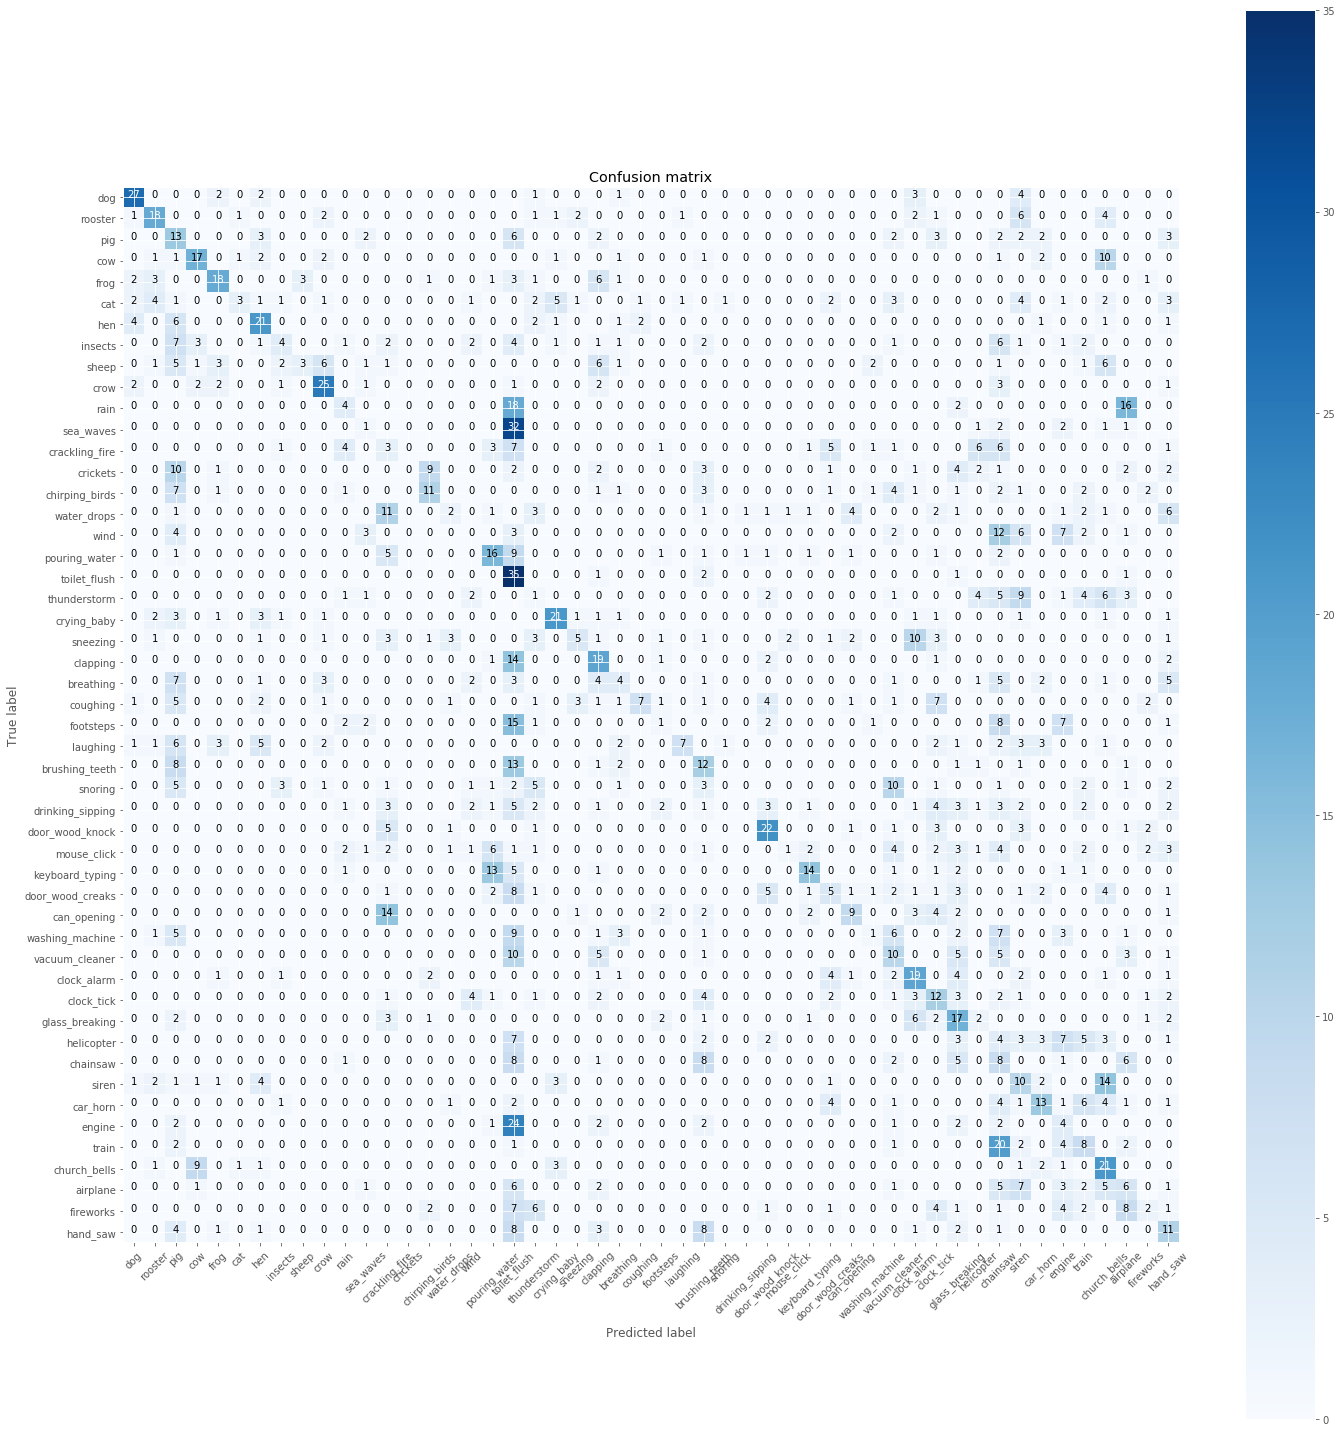

In [56]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

filename      1-100032-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                100032
take                         A
h_category                   0
Name: 0, dtype: object


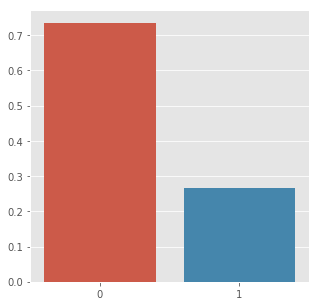

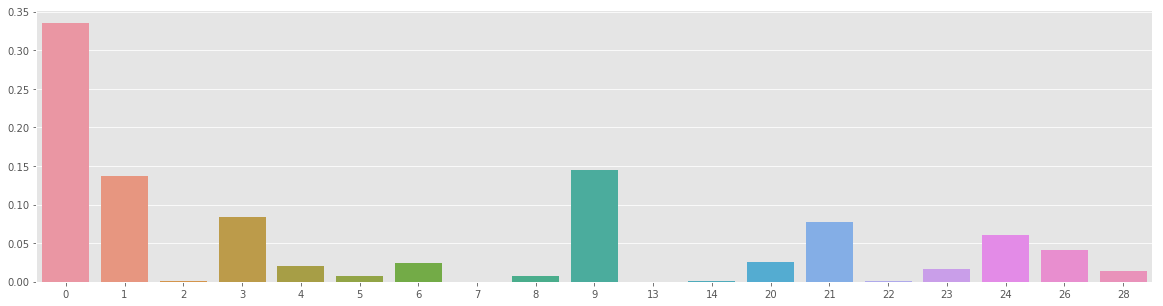

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


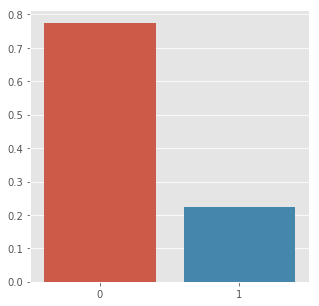

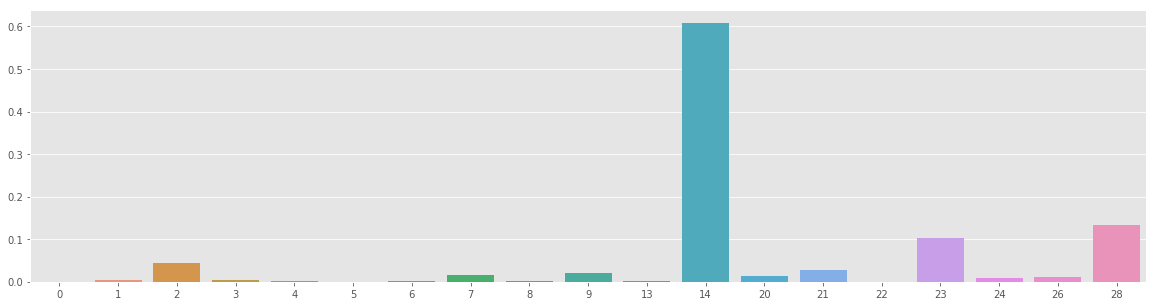

filename      1-100210-A-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          A
h_category                    1
Name: 2, dtype: object


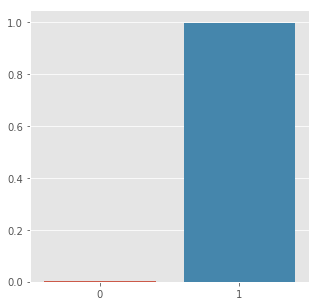

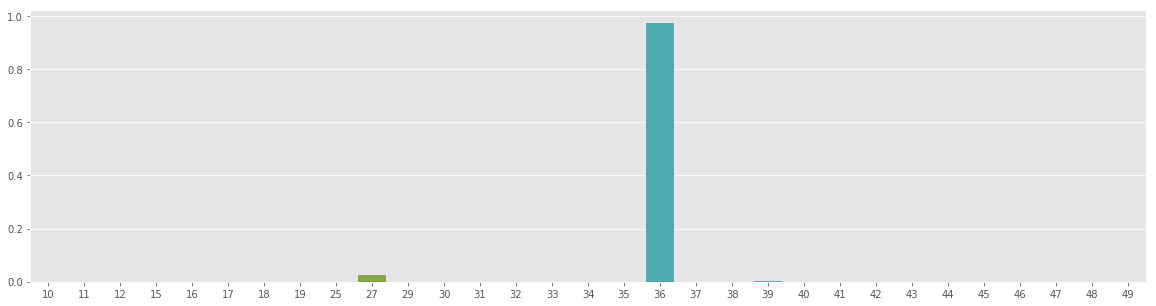

filename      1-100210-B-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          B
h_category                    1
Name: 3, dtype: object


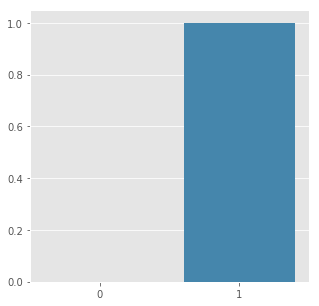

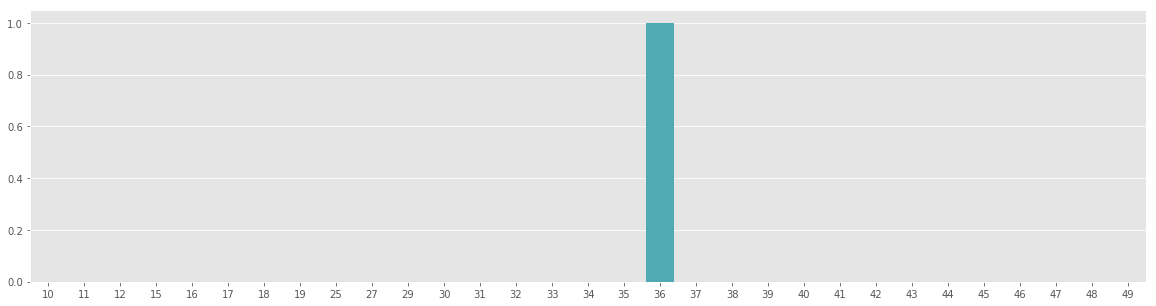

filename      1-101296-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          A
h_category                    1
Name: 4, dtype: object


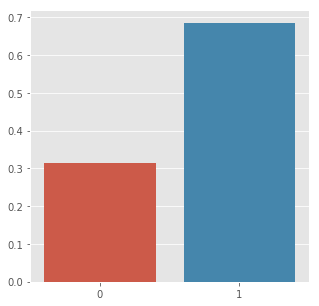

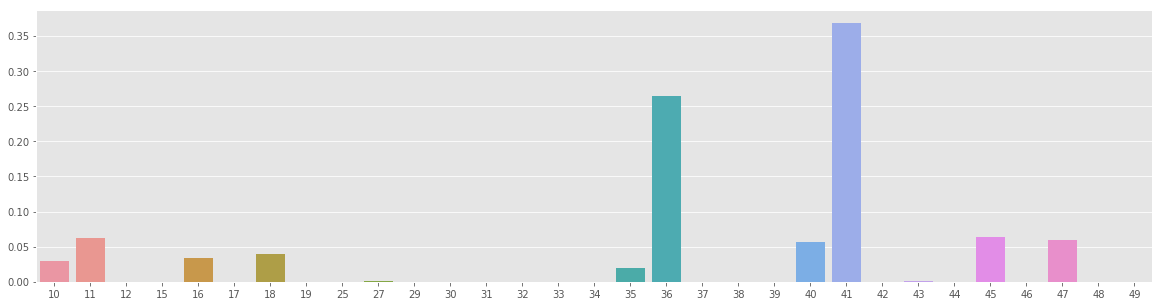

filename      1-101296-B-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          B
h_category                    1
Name: 5, dtype: object


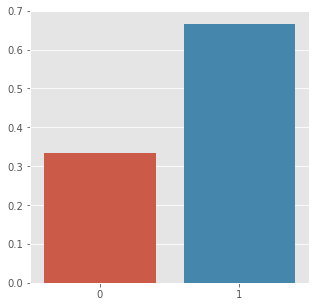

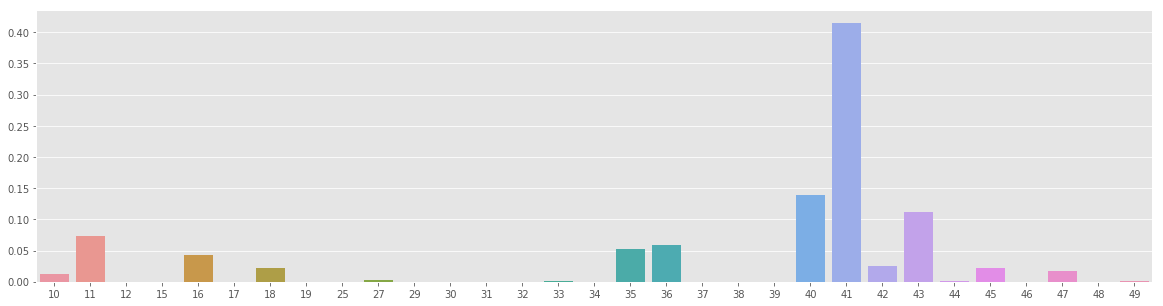

filename      1-101336-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 101336
take                          A
h_category                    1
Name: 6, dtype: object


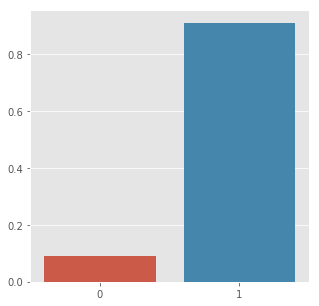

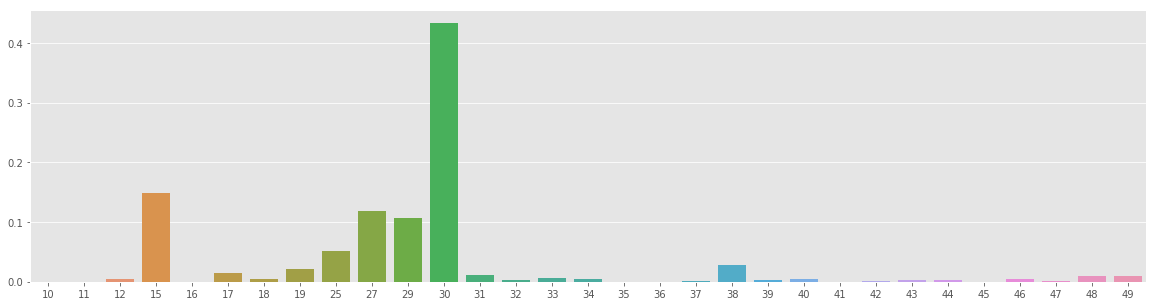

filename      1-101404-A-34.wav
fold                          1
target                       34
category            can_opening
esc10                     False
src_file                 101404
take                          A
h_category                    1
Name: 7, dtype: object


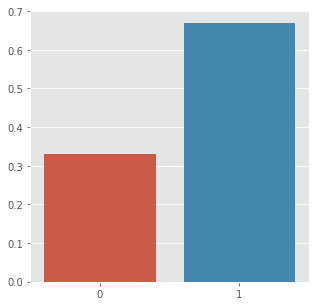

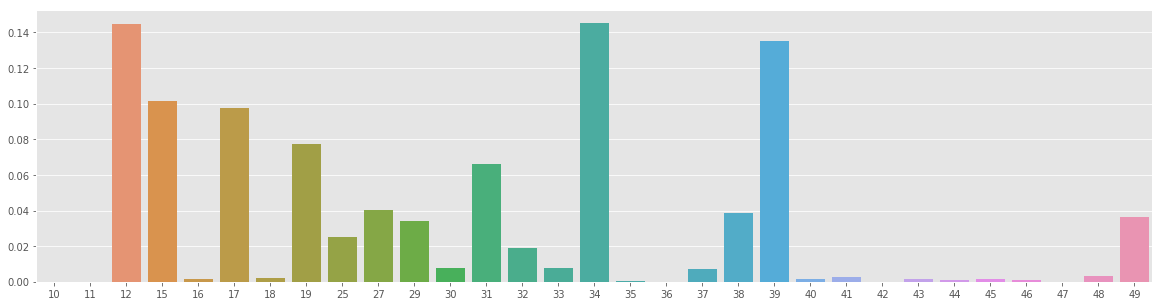

filename      1-103298-A-9.wav
fold                         1
target                       9
category                  crow
esc10                    False
src_file                103298
take                         A
h_category                   0
Name: 8, dtype: object


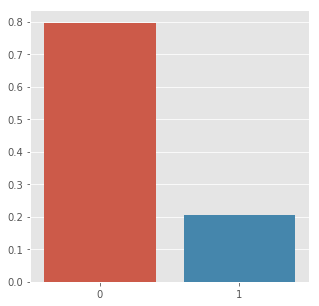

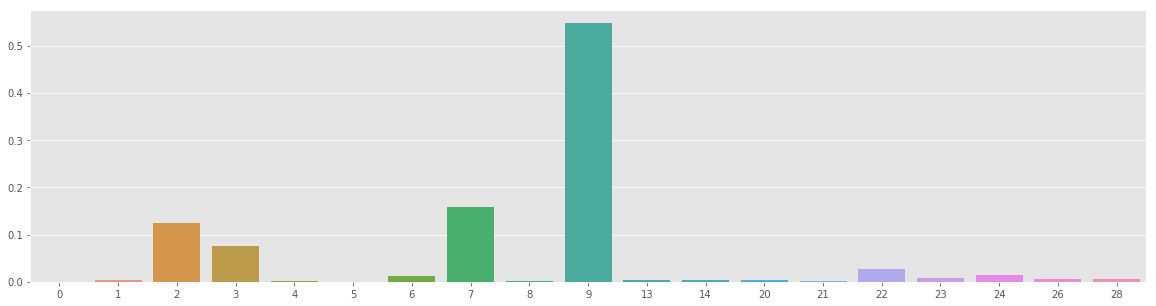

filename      1-103995-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103995
take                          A
h_category                    1
Name: 9, dtype: object


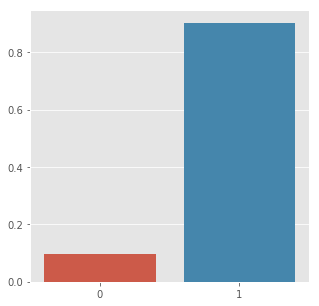

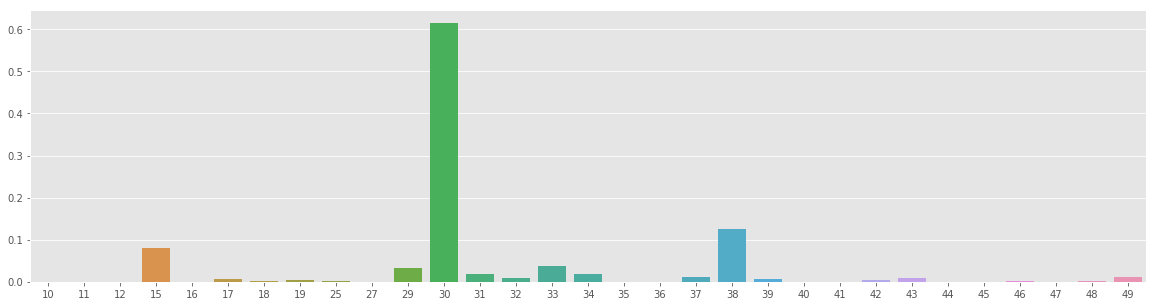

filename      1-103999-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103999
take                          A
h_category                    1
Name: 10, dtype: object


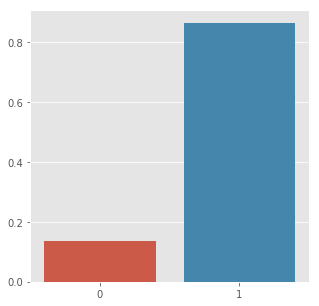

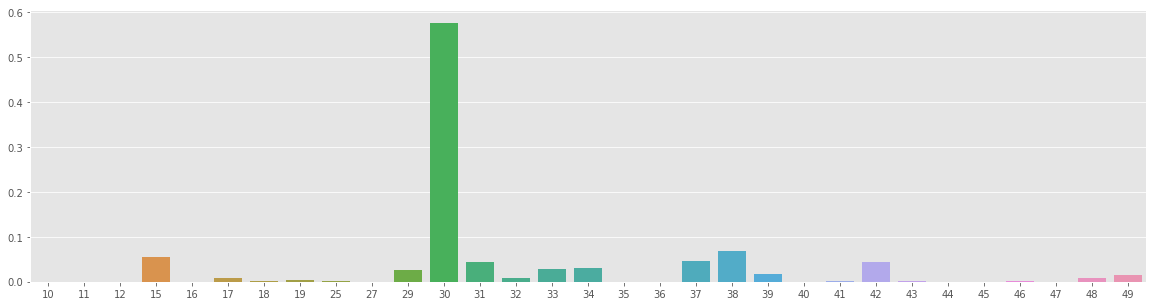

filename      1-104089-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          A
h_category                    0
Name: 11, dtype: object


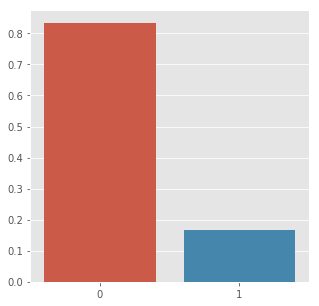

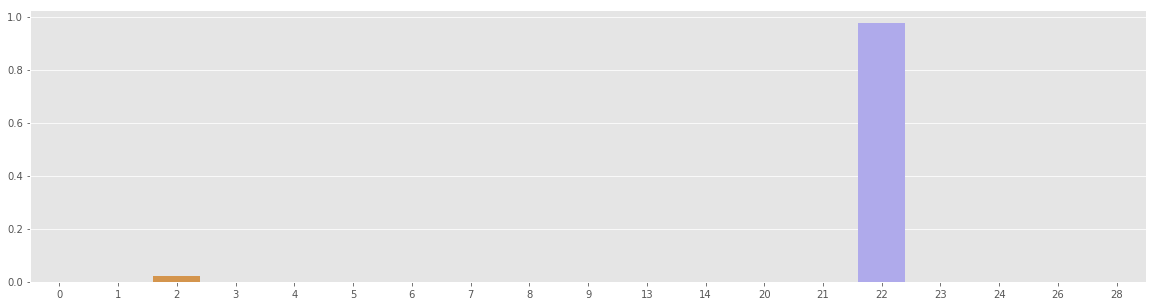

filename      1-104089-B-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          B
h_category                    0
Name: 12, dtype: object


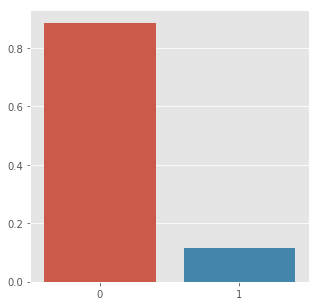

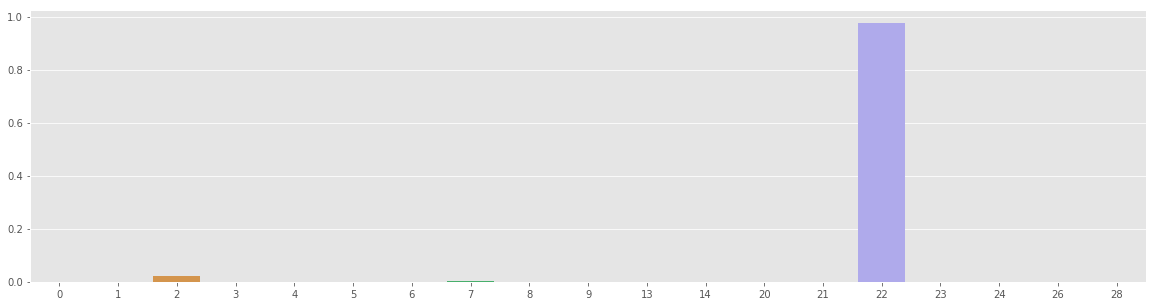

filename      1-105224-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 105224
take                          A
h_category                    0
Name: 13, dtype: object


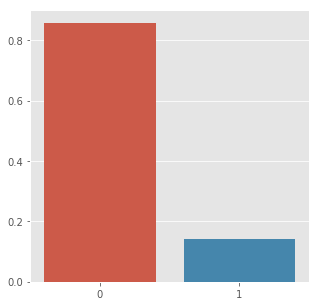

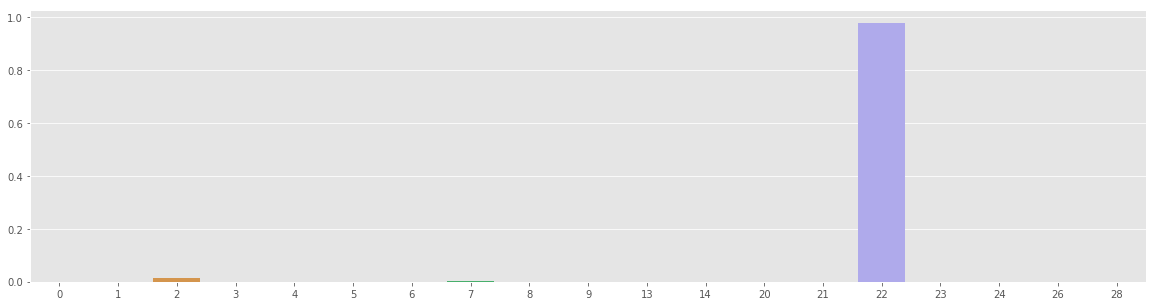

filename      1-110389-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                110389
take                         A
h_category                   0
Name: 14, dtype: object


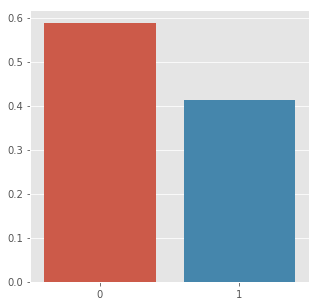

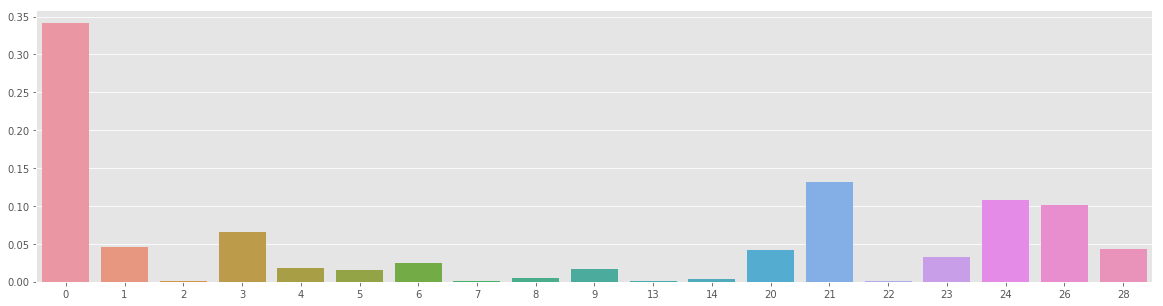

filename      1-110537-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 110537
take                          A
h_category                    0
Name: 15, dtype: object


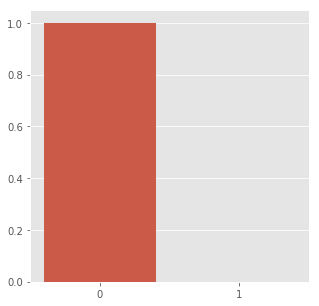

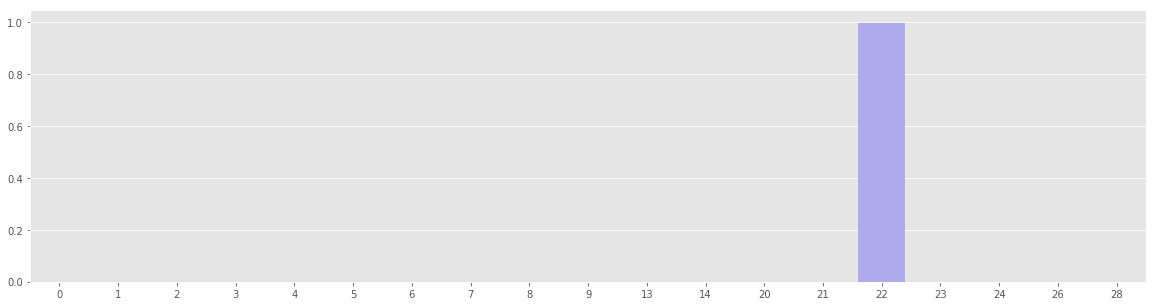

filename      1-115521-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 115521
take                          A
h_category                    1
Name: 16, dtype: object


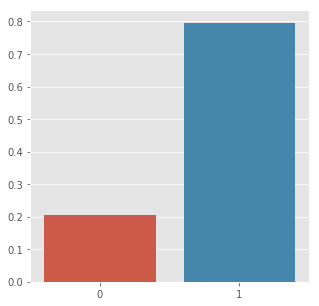

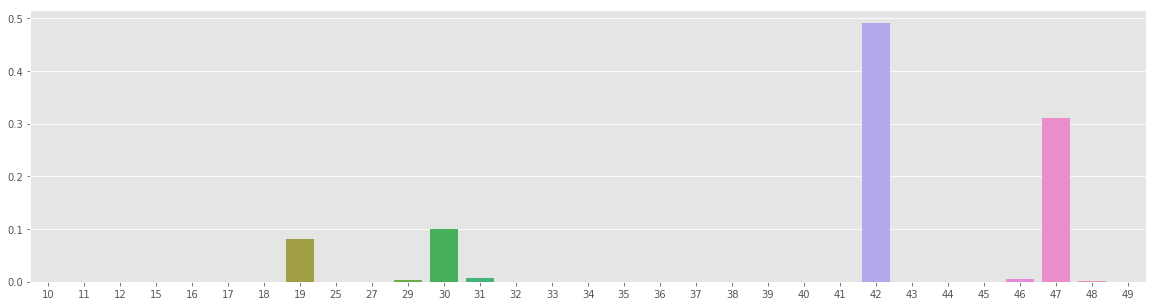

filename      1-115545-A-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          A
h_category                    1
Name: 17, dtype: object


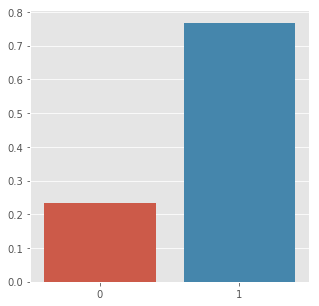

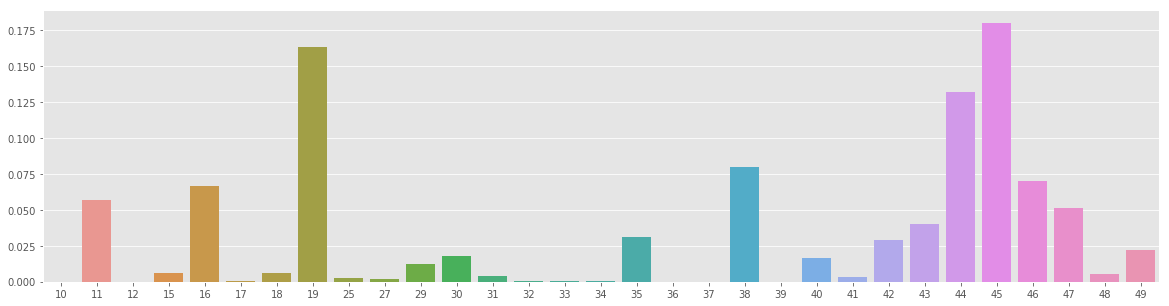

filename      1-115545-B-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          B
h_category                    1
Name: 18, dtype: object


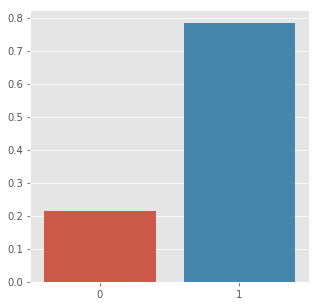

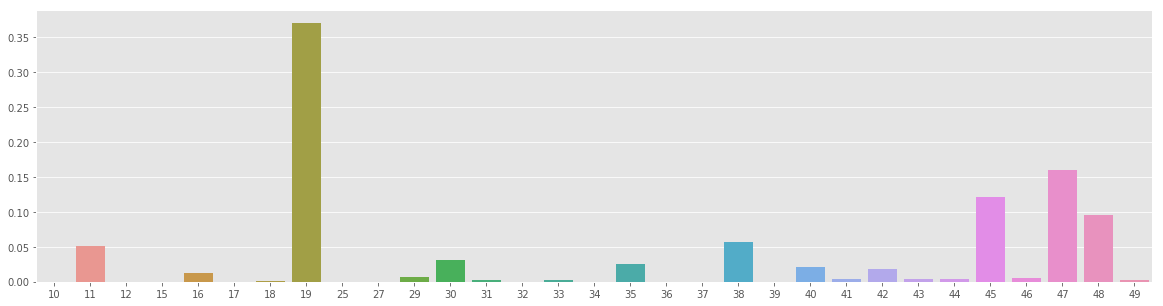

filename      1-115545-C-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          C
h_category                    1
Name: 19, dtype: object


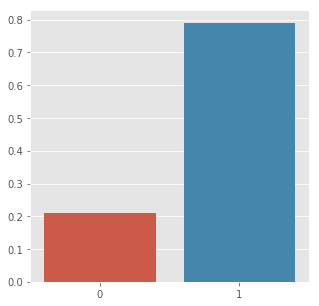

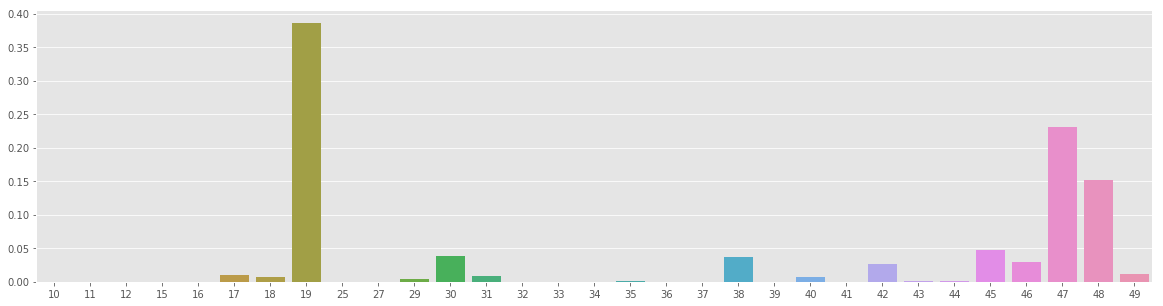

In [57]:
import seaborn as sns

for i in range(0,20):
    prob = pred_probs[i]
    print(dataset.iloc[i])

    xs = np.unique(targets)
    ys = np.average(top_pred_probs[i], axis=0)

    plt.figure(figsize=(5,5))
    sns.barplot(xs, ys)
    
    xs = np.unique(a_targ)
    ys = np.average(prob, axis=0)
    if(len(ys)!=len(xs)):
        xs = np.unique(i_targ)

    plt.figure(figsize=(20,5))
    sns.barplot(xs, ys)
    plt.show()